Data Mining 2019/20

In [1]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df = pd.read_csv('training.csv')

In [3]:
df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,326,1,10/25/2010,ADESA,2008,2,KIA,SPECTRA,EX,4D SEDAN EX,...,9605.0,10650.0,NaN,NaN,5546,33619,FL,6100.0,0,533
1,42991,0,5/27/2009,MANHEIM,2006,3,DODGE,STRATUS V6 2.7L V6 M,SXT,4D SEDAN SXT FFV,...,6418.0,7478.0,NaN,NaN,99750,32124,FL,4000.0,0,1630
2,55273,0,3/18/2010,OTHER,2008,2,DODGE,CALIBER,SE,4D WAGON,...,10721.0,11350.0,NaN,NaN,99761,74135,OK,7500.0,0,693
3,29058,0,6/8/2009,OTHER,2005,4,FORD,FREESTAR FWD V6 3.9L,S,PASSENGER 3.9L,...,5702.0,7691.0,NaN,NaN,99761,85018,AZ,4725.0,0,1633
4,34991,0,3/4/2009,MANHEIM,2005,4,CHRYSLER,TOWN & COUNTRY FWD V,Bas,MINIVAN 3.3L,...,6300.0,7856.0,NaN,NaN,20833,75236,TX,5670.0,0,1623


I tipi mi sembrano tutti giusti, considerando che degli attributi che sono int64 o float64, gli unici di cui ha senso calcolare la media sono tutti gli MMR, VehBCost, WarrantyCost, e volendo anche vehOdo, vehYear e vehAge. Gli altri son tutti o contatori (refId e BYRNO) o categorie (tutti gli altri)

In [4]:
df.describe()

,RefId,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
count,58386.000000,58386.000000,58386.000000,58386.000000,55813.000000,58386.000000,58373.000000,58373.000000,58373.000000,58373.000000,58141.000000,58141.000000,58141.000000,58141.000000,58386.000000,58386.000000,58386.000000,58386.000000,58386.000000
mean,36567.888449,0.123454,2005.344637,4.174956,1.495566,71478.090518,6128.127953,7372.912699,8497.288558,9851.768061,6131.666655,7389.958652,8776.065118,10145.227034,26359.191519,58125.258195,6730.008335,0.025674,1276.105042
std,21092.254801,0.328961,1.733307,1.713833,0.520802,14591.224550,2456.632611,2715.506462,3151.106237,3378.839613,2432.171539,2682.310828,3086.373733,3304.637060,25804.795573,26146.806098,1762.075265,0.158162,598.885423
min,1.000000,0.000000,2001.000000,0.000000,0.000000,4825.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,835.000000,2764.000000,1.000000,0.000000,462.000000
25%,18270.250000,0.000000,2004.000000,3.000000,1.000000,61785.000000,4273.000000,5409.000000,6279.000000,7501.000000,4275.000000,5415.000000,6538.000000,7788.000000,17212.000000,32124.000000,5430.000000,0.000000,837.000000
50%,36608.500000,0.000000,2005.000000,4.000000,1.000000,73359.000000,6097.000000,7308.000000,8448.000000,9798.000000,6063.000000,7311.000000,8733.000000,10103.000000,19662.000000,74135.000000,6700.000000,0.000000,1155.000000
75%,54811.500000,0.000000,2007.000000,5.000000,2.000000,82427.000000,7765.000000,9017.000000,10652.000000,12084.000000,7737.000000,9014.000000,10910.000000,12309.000000,22808.000000,80022.000000,7900.000000,0.000000,1623.000000
max,73014.000000,1.000000,2010.000000,9.000000,3.000000,115717.000000,35722.000000,36859.000000,39080.000000,41482.000000,35722.000000,36859.000000,39080.000000,41062.000000,99761.000000,99224.000000,36485.000000,1.000000,7498.000000


SCARTEREI:
PRIMEUNIT,AUCGUART
Dobbiamo ricordarci, in caso in cui consegnassimo alcune di queste tabelle nel report, di NON usare tutti gli attributi come in questo caso ma filtrare solo quelli per cui i valori mostrati hanno senso


In [5]:
sum_ = df.isnull().sum()
sum_[sum_ != 0]

Trim                                  1911
SubModel                                 7
Color                                    7
Transmission                             8
WheelTypeID                           2573
WheelType                             2577
Nationality                              4
Size                                     4
TopThreeAmericanName                     4
MMRAcquisitionAuctionAveragePrice       13
MMRAcquisitionAuctionCleanPrice         13
MMRAcquisitionRetailAveragePrice        13
MMRAcquisitonRetailCleanPrice           13
MMRCurrentAuctionAveragePrice          245
MMRCurrentAuctionCleanPrice            245
MMRCurrentRetailAveragePrice           245
MMRCurrentRetailCleanPrice             245
PRIMEUNIT                            55703
AUCGUART                             55703
dtype: int64

In [6]:
df.drop(columns=['RefId']).corr()

,IsBadBuy,VehYear,VehicleAge,WheelTypeID,VehOdo,MMRAcquisitionAuctionAveragePrice,MMRAcquisitionAuctionCleanPrice,MMRAcquisitionRetailAveragePrice,MMRAcquisitonRetailCleanPrice,MMRCurrentAuctionAveragePrice,MMRCurrentAuctionCleanPrice,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,BYRNO,VNZIP1,VehBCost,IsOnlineSale,WarrantyCost
IsBadBuy,1.000000,-0.156926,0.165325,-0.047693,0.082858,-0.105793,-0.099315,-0.084514,-0.080712,-0.106130,-0.101036,-0.100786,-0.097195,-0.059412,0.006393,-0.098132,-0.003969,0.050259
VehYear,-0.156926,1.000000,-0.958049,0.261366,-0.283569,0.582416,0.533807,0.582414,0.540206,0.591968,0.549345,0.599415,0.559579,0.281799,0.069976,0.349672,0.057316,-0.267739
VehicleAge,0.165325,-0.958049,1.000000,-0.252018,0.318778,-0.567106,-0.519897,-0.462299,-0.427526,-0.576914,-0.533646,-0.505322,-0.470640,-0.269907,-0.076617,-0.311903,-0.024659,0.257996
WheelTypeID,-0.047693,0.261366,-0.252018,1.000000,-0.212432,-0.094658,-0.129608,-0.071736,-0.101796,-0.086798,-0.120046,-0.072684,-0.101250,0.189817,0.007846,-0.160986,-0.011364,-0.133688
VehOdo,0.082858,-0.283569,0.318778,-0.212432,1.000000,-0.018381,0.023717,0.029107,0.061407,-0.030141,0.010755,0.013719,0.046070,-0.292230,-0.053547,-0.064436,0.030994,0.411273
MMRAcquisitionAuctionAveragePrice,-0.105793,0.582416,-0.567106,-0.094658,-0.018381,1.000000,0.990218,0.910185,0.909832,0.937482,0.931919,0.871220,0.870424,0.108806,0.047112,0.789354,0.038029,-0.049682
MMRAcquisitionAuctionCleanPrice,-0.099315,0.533807,-0.519897,-0.129608,0.023717,0.990218,1.000000,0.902339,0.917934,0.923144,0.931599,0.860055,0.870604,0.062818,0.041810,0.781123,0.037896,-0.019607
MMRAcquisitionRetailAveragePrice,-0.084514,0.582414,-0.462299,-0.071736,0.029107,0.910185,0.902339,1.000000,0.990085,0.851330,0.848776,0.912747,0.905523,0.107988,0.036402,0.745718,0.079767,-0.053507
MMRAcquisitonRetailCleanPrice,-0.080712,0.540206,-0.427526,-0.101796,0.061407,0.909832,0.917934,0.990085,1.000000,0.846393,0.854986,0.902680,0.906231,0.069857,0.032120,0.744622,0.076735,-0.026708
MMRCurrentAuctionAveragePrice,-0.106130,0.591968,-0.576914,-0.086798,-0.030141,0.937482,0.923144,0.851330,0.846393,1.000000,0.990244,0.915147,0.912305,0.112075,0.051706,0.778253,0.039513,-0.056893


Pandas è un bravo ragazzo, e ha eliminato di sua spontanea iniziativa PRIMEUNIT e AUCGUART. Ha anche tolto purchDate, auction, Make, Model, Trim, SubModel, Color, Transmission, WheelType (ha mantenuto l'id), Nationality, Size, TopThreeAmericanNames, VNST. 
- WarrantyCost e vehOdo: macchine con tanti km -> assicurazione costa tanto -> (forse) prob. bad buy?
C'è buona correlazione con tutti gli atttributi relativi al prezzo. Forse dobbiamo, più avanti, spendere un po' di tempo a cercare di cavare qualche variabile sensata da questi valori (che ne so, VehBCost/MMRAcquisitionAuctionAveragePrice e così via)

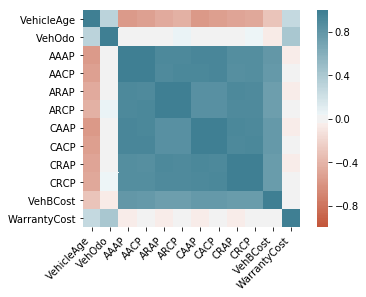

In [7]:
df.rename(columns={ 'MMRAcquisitionAuctionAveragePrice':'AAAP',
                    'MMRAcquisitionRetailAveragePrice':'ARAP',
                    'MMRCurrentAuctionAveragePrice':'CAAP',
                    'MMRCurrentRetailAveragePrice':'CRAP',
                    'MMRAcquisitionAuctionCleanPrice': 'AACP',
                    'MMRAcquisitonRetailCleanPrice': 'ARCP',
                    'MMRCurrentAuctionCleanPrice': 'CACP',
                    'MMRCurrentRetailCleanPrice': 'CRCP'
                  },inplace=True)

corr = df.drop(columns=['RefId',
        'VehYear',
        'IsBadBuy',
        'WheelTypeID',
        'BYRNO',
        'VNZIP1',
        'IsOnlineSale'],
        axis=1).corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

In [8]:
df.drop(columns=['RefId',
        'VehYear',
        'IsBadBuy',
        'WheelTypeID',
        'BYRNO',
        'VNZIP1',
        'IsOnlineSale'],
        axis=1).corr()

,VehicleAge,VehOdo,AAAP,AACP,ARAP,ARCP,CAAP,CACP,CRAP,CRCP,VehBCost,WarrantyCost
VehicleAge,1.000000,0.318778,-0.567106,-0.519897,-0.462299,-0.427526,-0.576914,-0.533646,-0.505322,-0.470640,-0.311903,0.257996
VehOdo,0.318778,1.000000,-0.018381,0.023717,0.029107,0.061407,-0.030141,0.010755,0.013719,0.046070,-0.064436,0.411273
AAAP,-0.567106,-0.018381,1.000000,0.990218,0.910185,0.909832,0.937482,0.931919,0.871220,0.870424,0.789354,-0.049682
AACP,-0.519897,0.023717,0.990218,1.000000,0.902339,0.917934,0.923144,0.931599,0.860055,0.870604,0.781123,-0.019607
ARAP,-0.462299,0.029107,0.910185,0.902339,1.000000,0.990085,0.851330,0.848776,0.912747,0.905523,0.745718,-0.053507
ARCP,-0.427526,0.061407,0.909832,0.917934,0.990085,1.000000,0.846393,0.854986,0.902680,0.906231,0.744622,-0.026708
CAAP,-0.576914,-0.030141,0.937482,0.923144,0.851330,0.846393,1.000000,0.990244,0.915147,0.912305,0.778253,-0.056893
CACP,-0.533646,0.010755,0.931919,0.931599,0.848776,0.854986,0.990244,1.000000,0.908620,0.921638,0.774637,-0.028245
CRAP,-0.505322,0.013719,0.871220,0.860055,0.912747,0.902680,0.915147,0.908620,1.000000,0.989693,0.756790,-0.058965
CRCP,-0.470640,0.046070,0.870424,0.870604,0.905523,0.906231,0.912305,0.921638,0.989693,1.000000,0.756551,-0.032932


## Colonne rinominate con gli acronimi per cercare di capire qualcosa 
## +
## Rimosse tutte le colonne "CleanPrice"

Si può già notare come la colonna "VehicleAge" sia inversamente correlata (-0.6 circa) con il prezzo. 

Ciò ha molto senso dato che le auto 🚗 perdono valore con il passare degli anni. 😎

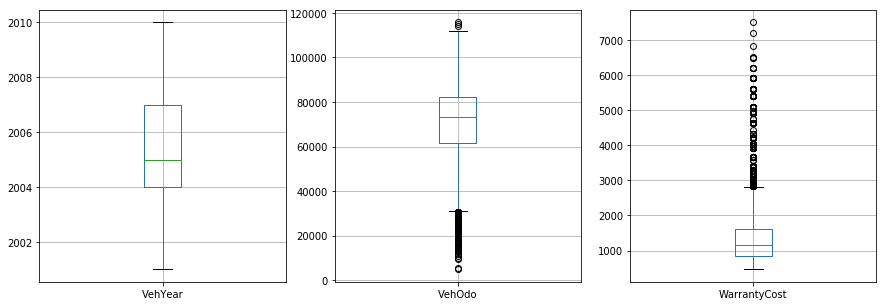

In [9]:
fig = plt.figure(figsize=(15, 5)) 
fig_dims = (1, 3)

plt.subplot2grid(fig_dims, (0, 0))
df.boxplot(column=['VehYear'])

plt.subplot2grid(fig_dims, (0, 1))
df.boxplot(column=['VehOdo'])


plt.subplot2grid(fig_dims, (0, 2))
df.boxplot(column=['WarrantyCost'])

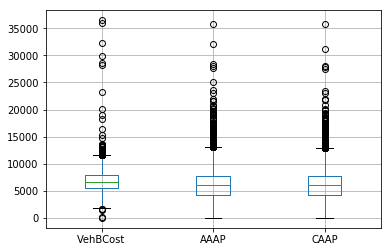

In [10]:
df.boxplot(column=['VehBCost','AAAP','CAAP'])

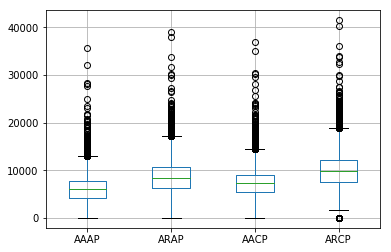

In [11]:
df.boxplot(column=['AAAP', 'ARAP', 'AACP', 'ARCP'])

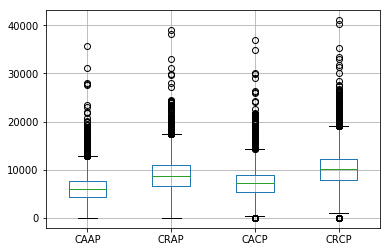

In [12]:
df.boxplot(column=['CAAP','CRAP','CACP','CRCP'])

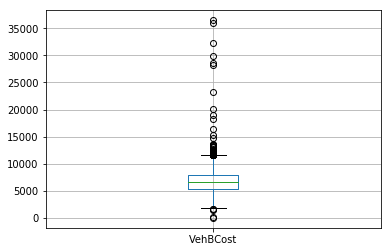

In [13]:
df.boxplot(column=['VehBCost'])

# Da provare prezzi/marca

In [14]:
pclass_xt = pd.crosstab(df['Transmission'], df['WheelType'])
pclass_xt

WheelType,Alloy,Covers,Special
Transmission,,,
AUTO,27797,25432,539
MANUAL,937,1053,50


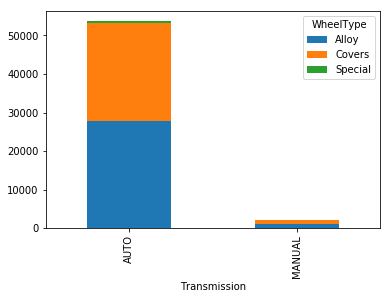

In [15]:
pclass_xt.plot(kind='bar', stacked=True)

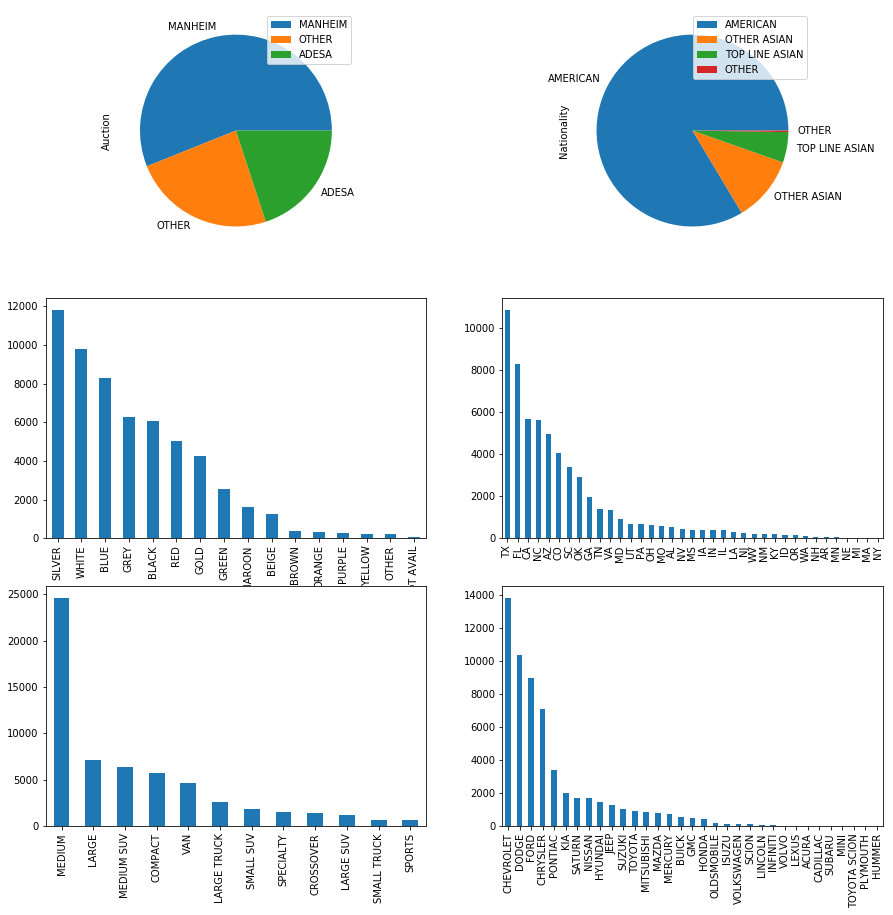

In [16]:
fig = plt.figure(figsize=(15, 15)) 
fig_dims = (3, 2)

plt.subplot2grid(fig_dims, (0, 0))
df['Auction'].value_counts().plot.pie(legend=True)

plt.subplot2grid(fig_dims, (0, 1))
df['Nationality'].value_counts().plot.pie(legend=True)

plt.subplot2grid(fig_dims, (1, 0))
df['Color'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (1, 1))
df['VNST'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (2, 0))
df['Size'].value_counts().plot(kind='bar')

plt.subplot2grid(fig_dims, (2, 1))
df['Make'].value_counts().plot(kind='bar')

In [17]:
df['BYRNO'].value_counts()

99761    3191
18880    2852
835      2398
3453     2362
22916    2285
21053    2267
19619    2173
99750    2136
20928    2099
17675    2066
21973    2010
17212    2006
20740    1895
5546     1775
18111    1707
18822    1689
8655     1688
23359    1673
20234    1641
20833    1604
19638    1490
22808    1466
18881    1380
16044    1309
25100    1308
19662    1211
20207    1068
16926    1066
52117     972
8172      886
         ... 
21047     117
1191       83
53245      67
1051       55
1151       54
1045       52
1085       43
10310      39
1081       30
11410      28
1031       26
1121       17
1141       14
1156        9
1035        9
18091       9
10410       8
1125        7
1055        7
1082        5
1152        5
1041        5
16369       5
11210       4
10510       3
10420       3
1157        1
10425       1
99741       1
1086        1
Name: BYRNO, Length: 72, dtype: int64

In [18]:
df.apply(lambda x : 'refID'==326)

RefId                   False
IsBadBuy                False
PurchDate               False
Auction                 False
VehYear                 False
VehicleAge              False
Make                    False
Model                   False
Trim                    False
SubModel                False
Color                   False
Transmission            False
WheelTypeID             False
WheelType               False
VehOdo                  False
Nationality             False
Size                    False
TopThreeAmericanName    False
AAAP                    False
AACP                    False
ARAP                    False
ARCP                    False
CAAP                    False
CACP                    False
CRAP                    False
CRCP                    False
PRIMEUNIT               False
AUCGUART                False
BYRNO                   False
VNZIP1                  False
VNST                    False
VehBCost                False
IsOnlineSale            False
WarrantyCo

In [19]:
df['WheelTypeIDDelete'] = df['WheelTypeID'].fillna(4)

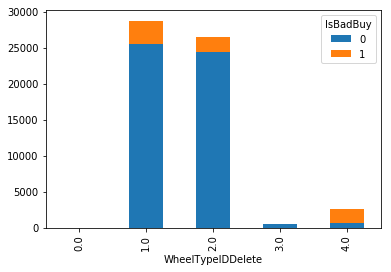

In [20]:
pclass_xt = pd.crosstab(df['WheelTypeIDDelete'], df['IsBadBuy'])
pclass_xt.plot(kind='bar', stacked=True)

Adesso cerco di trovare alcuni valori sbagliati (prezzi < 0, prezzi anomali, cose così)

In [21]:
len(df[df['VehBCost'] <= 0]) # numero di elementi in cui il costo è <= 0

0

In [22]:
len([(x, y) for x, y in zip(df['VehBCost'], df['ARCP']) if x > y and y != 0])
#([(x, y, z, odo, year) for x, y, z, odo, year in zip(df['VehBCost'], df['ARCP'], df['Trim'], df['VehOdo'], df['VehYear']) if x > y and y != 0])

2919

Per vedere la lista basta che togliete il commento alla seconda linea.
Non so a me questo sembra assurdo, però pare che sia normale. 2919 macchine sono state acquistate a prezzo maggiore rispetto a quello del concessionario. Questo vale anche per macchine comprate in opzione base ('Bas' nella terza colonna), e con alto chilometraggio. Ci ho messo anche l'anno del veicolo per far capire che non si tratta di auto d'epoca, quindi davvero non ho idea.
Secondo me è una cosa che vale la pena scrivere nel report: macchine vengono anche acquistate a un prezzo maggiore del concessionario anche se usate. Unica cosa dobbiamo capire se in retail ci stanno anche auto usate, e allora quindi tutto questo discorso non vale nulla. Inizialmente speravo di usare questo come controllo che i dati fossero corretti, però...

In [23]:
len([(y, a) for y, a in zip(df['VehYear'], df['VehicleAge']) if a+y < 2009 or a+y > 2010]) # gli anni son tutti corretti

0

In [24]:
len(df[df['VehOdo'] <= 0]) # numero di elementi in cui il contakm è <= 0

0

In [25]:
len(df[df['WarrantyCost'] <= 0]) # numero di elementi in cui il costo della garanzia è <= 0

0

Adesso verifico che in ogni caso, l'acquisto di un veicolo clean (above average condition) costi di più di quello medio (e infatti torna sempre perfetto in ogni caso

In [26]:
len([(x,y) for x,y in zip(df['AAAP'], df['AACP']) if x>y])

0

In [27]:
len([(x,y) for x,y in zip(df['ARAP'], df['ARCP']) if x>y])

0

In [28]:
len([(x,y) for x,y in zip(df['CAAP'], df['CACP']) if x>y])

0

In [29]:
len([(x,y) for x,y in zip(df['CRAP'], df['CRCP']) if x>y])

0

A questo punto cerco di risolvere qualche missing value:
Tutti i currentAuction hanno 250 missing values circa. Pensavo di sostituire, quando quelli medi sono disponibili, current con quelli medi

In [30]:
print(df.at[292, 'CAAP']) # abbiamo 245 missing values, e quello alla riga 292 è un missing value
df['CAAP'].isnull().sum()

nan


245

In [31]:
df['CAAP'].fillna(df['AAAP'],inplace=True)
print(df['CAAP'].isnull().sum()) # ho 13 missing values, che sono quelli di cui mi manca anche il valore medio
print(df.at[292, 'CAAP'] == df.at[292, 'AAAP']) # Ha correttamente riempito CAAP con il valore in AAAP all'id 292

13
True


Adesso devo fare la stessa cosa per gli altri current values

In [32]:
df['CRAP'].fillna(df['ARAP'],inplace=True)
df['CACP'].fillna(df['AACP'],inplace=True)
df['CRCP'].fillna(df['ARCP'],inplace=True)

Qua secondo me è simpatico per far  notare che in generale i bad buy si trovano in 3 zone
- Su macchine praticamente nuove (contakm basso e costo garanzia basso)
- Su macchine usate e rischiose (garanzia alta, contakm intorno a 40000-80000
- Su macchine stra usate

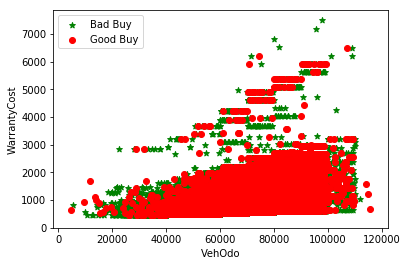

In [33]:
plt.scatter(df[df['IsBadBuy'] == 0]['VehOdo'], 
            df[df['IsBadBuy'] == 0]['WarrantyCost'], color='g', marker='*', label='Bad Buy')
plt.scatter(df[df['IsBadBuy'] == 1]['VehOdo'], 
            df[df['IsBadBuy'] == 1]['WarrantyCost'], color='r',label='Good Buy')
plt.xlabel('VehOdo')
plt.ylabel('WarrantyCost')
plt.legend()
plt.show()

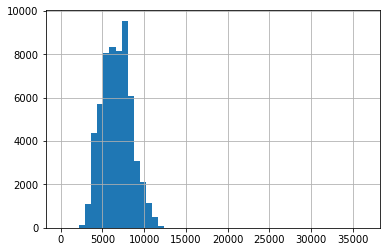

In [34]:
df['VehBCost'].hist(bins=50)
plt.show()

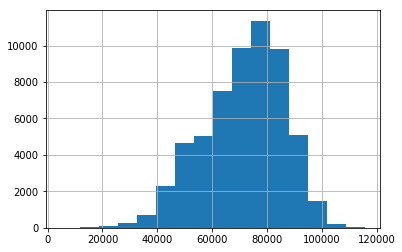

In [35]:
df['VehOdo'].hist(bins=16)
plt.show()

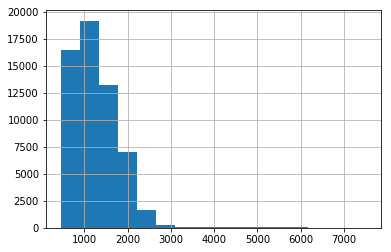

In [36]:
df['WarrantyCost'].hist(bins=16)
plt.show()

## Variable Sostitution & Redundancy Elimination

In [37]:
PAC = ['WA' ,'OR','AK','HI','CA']
MNT = ['MT' ,'WY','ID','NV','UT','CO','AZ','NM']
WNC = ['ND' ,'MN','SD','IA','NE','KS','MO']
WSC = ['OK' ,'AR','TX','LA']
ENC = ['WI' ,'MI','OH','IN','IL']
ESC = ['KY' ,'TN','MS','AL']
MAT = ['NY' ,'PA','NJ']
SAT = ['WV' ,'MD','DE','DC','VA','NC','SC','GA','FL']
NEN = ['ME' ,'NH','VT','MA','CT','RI']

In [38]:
sost = []
for i in df['VNST']:
    if i in PAC:
        sost.append('PAC')
    elif i in MNT:
        sost.append('MNT')
    elif i in WNC:
        sost.append('WNC')
    elif i in WSC:
        sost.append('WSC')
    elif i in ENC:
        sost.append('ENC')
    elif i in ESC:
        sost.append('ESC')
    elif i in MAT:
        sost.append('MAT')
    elif i in SAT:
        sost.append('SAT')
    elif i in NEN:
        sost.append('NEN')
    else:
        sost.append('XXX')

df['Region'] = sost

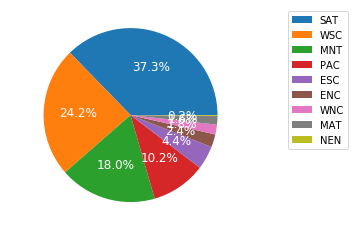

In [39]:
plot = df['Region'].value_counts().plot.pie(legend=True,autopct='%1.1f%%',textprops=dict(color="w",size="12"))
plot.legend(bbox_to_anchor=(1.2,1), loc="upper left")
plot.axes.get_yaxis().set_visible(False)

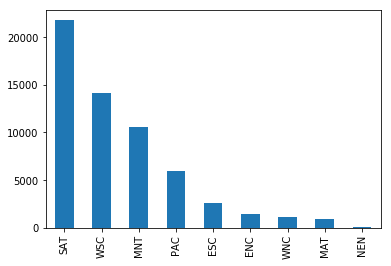

In [40]:
plot = df['Region'].value_counts().plot(kind='bar')

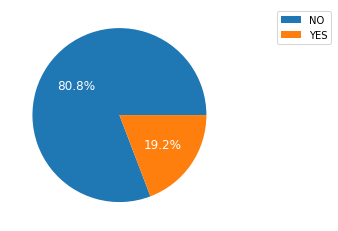

In [41]:
sost = []

for i in df['Trim']:
    if i == 'Bas':
        sost.append('YES')
    else:
        sost.append("NO")

df['IsBase'] = sost
plot = df['IsBase'].value_counts().plot.pie(legend=True,autopct='%1.1f%%',textprops=dict(color="w",size="12"))
plot.legend(bbox_to_anchor=(1.2,1), loc="upper left")
plot.axes.get_yaxis().set_visible(False)

In [42]:
df['IsBase'].isnull().sum()

0

### Eliminazione variabili (idee)

- VehicleYear
- AUCGUART
- PRIMEUNIT
- 

In [43]:
sum_ = df.isnull().sum()
sum_[sum_ != 0]

Trim                     1911
SubModel                    7
Color                       7
Transmission                8
WheelTypeID              2573
WheelType                2577
Nationality                 4
Size                        4
TopThreeAmericanName        4
AAAP                       13
AACP                       13
ARAP                       13
ARCP                       13
CAAP                       13
CACP                       13
CRAP                       13
CRCP                       13
PRIMEUNIT               55703
AUCGUART                55703
dtype: int64

Per sostituire WheelType ci accorgiamo che raggruppando su IsBase abbiamo mode diverse per i due gruppi

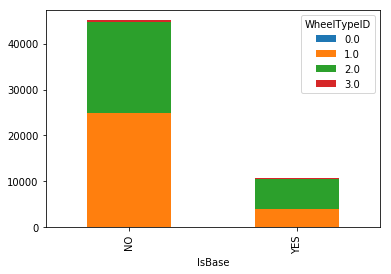

In [44]:
pclass_xt = pd.crosstab(df['IsBase'], df['WheelTypeID'])
pclass_xt.plot(kind='bar', stacked=True)

Sostituisco tutti i missing values di WheelType ID con la moda del gruppo relativo a trim base o no: se il veicolo non è base allora alloy è la moda (vedi grafico sopra)...

In [45]:
df['WheelTypeID'] = df.groupby(['IsBase']).WheelTypeID.apply(lambda x: x.fillna(x.mode()[0]))
df['WheelTypeID'].isnull().sum()

0

Non faccio niente con wheelType perchè secondo me quell'attributo va frullato, tanto è ridondante con wheelTypeID

Per quanto riguarda nationality, ci accorgiamo che i missing values sono tutti di marche americane. Quindi TopThreeAmericanName sarà OTHER in ogni caso, e nationality sarà american

In [46]:
df[df['Nationality'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make', 'Nationality']]

,TopThreeAmericanName,Transmission,Model,Make,Nationality
15769,NaN,AUTO,SIERRA 1500,GMC,NaN
18532,NaN,AUTO,NITRO 4WD V6,DODGE,NaN
20016,NaN,AUTO,PATRIOT 2WD 4C,JEEP,NaN
35157,NaN,AUTO,PATRIOT 2WD 4C,JEEP,NaN


In [47]:
df['TopThreeAmericanName'].fillna('OTHER', inplace=True)
df['TopThreeAmericanName'].isnull().sum()

0

In [48]:
df['Nationality'].fillna('OTHER', inplace=True)
df['Nationality'].isnull().sum()

0

Addesso controlliamo i missing values di transmission, e notiamo che la distribuzione è molto più vicina al cambio automatico rispetto a quello manuale, quindi usiamo la moda. Inoltre guardando i missing values notiamo che son tutte macchine americane.

In [49]:
df[df['Transmission'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make']]

,TopThreeAmericanName,Transmission,Model,Make
23019,GM,NaN,IMPALA 3.4L V6 SFI,CHEVROLET
28280,FORD,NaN,FREESTAR FWD V6 3.9L,FORD
28961,GM,NaN,GRAND AM V6 3.4L V6,PONTIAC
33225,FORD,NaN,MOUNTAINEER 2WD V8 4,MERCURY
35224,CHRYSLER,NaN,STRATUS V6 2.7L V6 M,DODGE
40504,FORD,NaN,MONTEGO 3.0L V6 EFI,MERCURY
48641,CHRYSLER,NaN,STRATUS V6 2.7L V6 M,DODGE
50661,GM,NaN,S10 PICKUP 2WD 4C 2.,CHEVROLET


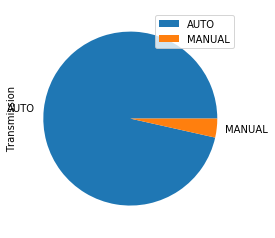

In [50]:
df['Transmission'].value_counts().plot.pie(legend=True)

In [51]:
df['Transmission'].fillna(df['Transmission'].mode()[0], inplace=True)
df['Transmission'].isnull().sum()

0

Per quanto riguarda il colore, abbiamo provato a raggruppare sugli attributi significativi (make, size, year), ma comunque sia la moda era sempre SILVER. 

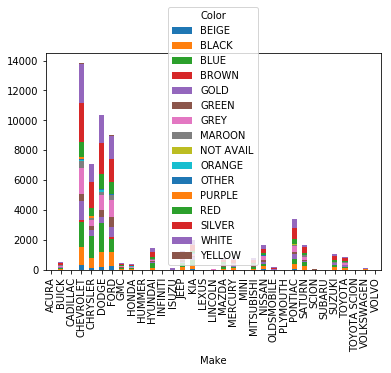

In [52]:
pclass_xt = pd.crosstab(df['Make'], df['Color'])
pclass_xt.plot(kind='bar', stacked=True)

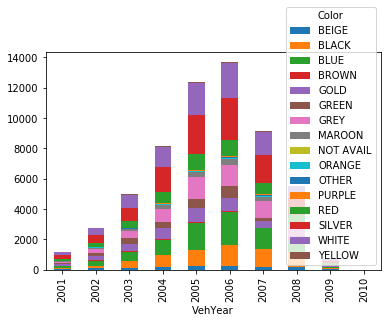

In [53]:
pclass_xt = pd.crosstab(df['VehYear'], df['Color'])
pclass_xt.plot(kind='bar', stacked=True)

In [54]:
df[df['Color'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make', 'Color']]

,TopThreeAmericanName,Transmission,Model,Make,Color
23019,GM,AUTO,IMPALA 3.4L V6 SFI,CHEVROLET,NaN
28280,FORD,AUTO,FREESTAR FWD V6 3.9L,FORD,NaN
28961,GM,AUTO,GRAND AM V6 3.4L V6,PONTIAC,NaN
33225,FORD,AUTO,MOUNTAINEER 2WD V8 4,MERCURY,NaN
35224,CHRYSLER,AUTO,STRATUS V6 2.7L V6 M,DODGE,NaN
48641,CHRYSLER,AUTO,STRATUS V6 2.7L V6 M,DODGE,NaN
50661,GM,AUTO,S10 PICKUP 2WD 4C 2.,CHEVROLET,NaN


In [55]:
df['Color'].fillna(df['Color'].mode()[0], inplace=True) #Sostituisco con la moda che è silver
df['Color'].isnull().sum()

0

Adesso size, abbiamo notato che marche diverse hanno distribuzioni diversi, quindi raggruppiamo su make e prendiamo la moda

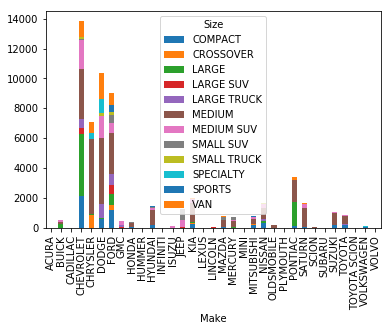

In [56]:
pclass_xt = pd.crosstab(df['Make'], df['Size'])
pclass_xt.plot(kind='bar', stacked=True)

In [57]:
df[df['Size'].isnull()][['TopThreeAmericanName', 'Transmission', 'Model', 'Make', 'Color']]

,TopThreeAmericanName,Transmission,Model,Make,Color
15769,OTHER,AUTO,SIERRA 1500,GMC,WHITE
18532,OTHER,AUTO,NITRO 4WD V6,DODGE,WHITE
20016,OTHER,AUTO,PATRIOT 2WD 4C,JEEP,SILVER
35157,OTHER,AUTO,PATRIOT 2WD 4C,JEEP,BLACK


In [58]:
df['Size'] = df.groupby(['Make']).Size.apply(lambda x: x.fillna(x.mode()[0]))
df['Size'].isnull().sum()

0

Sub model è strano, ho pensato di raggruppare su make e modello, e prendere la moda di quello

In [59]:
df[df['SubModel'].isnull()][['TopThreeAmericanName', 'Nationality', 'Model', 'Make', 'SubModel']]

,TopThreeAmericanName,Nationality,Model,Make,SubModel
23019,GM,AMERICAN,IMPALA 3.4L V6 SFI,CHEVROLET,NaN
28280,FORD,AMERICAN,FREESTAR FWD V6 3.9L,FORD,NaN
28961,GM,AMERICAN,GRAND AM V6 3.4L V6,PONTIAC,NaN
33225,FORD,AMERICAN,MOUNTAINEER 2WD V8 4,MERCURY,NaN
35224,CHRYSLER,AMERICAN,STRATUS V6 2.7L V6 M,DODGE,NaN
48641,CHRYSLER,AMERICAN,STRATUS V6 2.7L V6 M,DODGE,NaN
50661,GM,AMERICAN,S10 PICKUP 2WD 4C 2.,CHEVROLET,NaN


In [60]:
df['SubModel'] = df.groupby([df['Make'], df['Model']]).Size.apply(lambda x: x.fillna(x.mode()[0]))
df['SubModel'].isnull().sum()

0

In [61]:
sum_ = df.isnull().sum()
sum_[sum_ != 0]

Trim          1911
WheelType     2577
AAAP            13
AACP            13
ARAP            13
ARCP            13
CAAP            13
CACP            13
CRAP            13
CRCP            13
PRIMEUNIT    55703
AUCGUART     55703
dtype: int64

Perfetto, a questo punto nessun missing value è rimasto. Dobbiamo solo inserire la/e variabile/i da aggiungere per le medie, rimuovere quelle inutili

In [62]:
df.sort_values(['VehBCost'])['VehBCost'].head()

40998       1.0
53937     225.0
26371    1400.0
31167    1620.0
26693    1720.0
Name: VehBCost, dtype: float64

In [63]:
tresh = 1000
to_delete = df[(df['AAAP'] < tresh) & 
   (df['AACP'] < tresh) &
   (df['ARAP'] < tresh) &
   (df['ARCP'] < tresh) &
   (df['CAAP'] < tresh) &
   (df['CACP'] < tresh) &
   (df['CRAP'] < tresh) &
   (df['CRCP'] < tresh)].index.tolist()
print(len(to_delete))
new_df = df.drop(index=to_delete)
df['RefId'].count() - new_df['RefId'].count()

358


358

In [64]:
new_df.drop(columns=['RefId',
    'VehYear',
    'IsBadBuy',
    'WheelTypeID',
    'BYRNO',
    'VNZIP1',
    'IsOnlineSale'],
    axis=1).corr()


,VehicleAge,VehOdo,AAAP,AACP,ARAP,ARCP,CAAP,CACP,CRAP,CRCP,VehBCost,WarrantyCost,WheelTypeIDDelete
VehicleAge,1.000000,0.320002,-0.581877,-0.535764,-0.476483,-0.442748,-0.592594,-0.550280,-0.521719,-0.488002,-0.312987,0.261454,-0.145939
VehOdo,0.320002,1.000000,-0.019028,0.024102,0.029627,0.063008,-0.032612,0.009754,0.012720,0.046533,-0.064522,0.412344,-0.133822
AAAP,-0.581877,-0.019028,1.000000,0.989953,0.906420,0.906138,0.935198,0.929266,0.865684,0.864783,0.805163,-0.047308,-0.088852
AACP,-0.535764,0.024102,0.989953,1.000000,0.897719,0.913844,0.920048,0.928517,0.853234,0.863996,0.799565,-0.016191,-0.113010
ARAP,-0.476483,0.029627,0.906420,0.897719,1.000000,0.989741,0.845124,0.841790,0.908850,0.901179,0.763013,-0.051108,-0.071458
ARCP,-0.442748,0.063008,0.906138,0.913844,0.989741,1.000000,0.839603,0.847716,0.897830,0.901208,0.764795,-0.023292,-0.092343
CAAP,-0.592594,-0.032612,0.935198,0.920048,0.845124,0.839603,1.000000,0.989929,0.911358,0.908476,0.794446,-0.055172,-0.083634
CACP,-0.550280,0.009754,0.929266,0.928517,0.841790,0.847716,0.989929,1.000000,0.903954,0.917483,0.793682,-0.025264,-0.107537
CRAP,-0.521719,0.012720,0.865684,0.853234,0.908850,0.897830,0.911358,0.903954,1.000000,0.989273,0.776455,-0.056868,-0.075764
CRCP,-0.488002,0.046533,0.864783,0.863996,0.901179,0.901208,0.908476,0.917483,0.989273,1.000000,0.779301,-0.029603,-0.096033


In [65]:
sum_ = new_df.isnull().sum()
sum_[sum_ != 0]

Trim          1908
WheelType     2555
AAAP            13
AACP            13
ARAP            13
ARCP            13
CAAP            13
CACP            13
CRAP            13
CRCP            13
PRIMEUNIT    55348
AUCGUART     55348
dtype: int64

In [66]:
new_df.drop(columns=['Trim', 'WheelType', 'PRIMEUNIT', 'AUCGUART'], inplace=True)

sum_ = new_df.isnull().sum()
sum_[sum_ != 0]

AAAP    13
AACP    13
ARAP    13
ARCP    13
CAAP    13
CACP    13
CRAP    13
CRCP    13
dtype: int64

In [67]:
new_df.dropna(inplace=True)

sum_ = new_df.isnull().sum()
sum_[sum_ != 0]

Series([], dtype: int64)

In [68]:
new_df.to_csv('training_cleaned.csv')